# Important note

1. This notebook is built upon this quickstarter by https://www.kaggle.com/code/ambrosm/msci-multiome-quickstart

2. It reads the Multime traning data in sparse mode,from this dataset: https://www.kaggle.com/datasets/sbunzini/open-problems-msci-multiome-sparse-matrices

3. During CV this NB reads the whole training dataset,in four chunks. It takes 33 minutes to complete.

4. It uses truncatedSVD for reducing the number of features, to 512.

5. The model is Ridge. I tried LinearRegression and KNN  (very fast) and DecisionTrees, LinearSVD (dual=False),LGBM and CatBoost (excruciatingly slow).

6. The CV is about 0.658, which is not an improvement. 

I hope this helps.

# Multiome Quickstart

This notebook shows how to cross-validate a baseline model and create a submission for the Multiome part of the *Multimodal Single-Cell Integration* competition without running out of memory.

It does not show the EDA - see the separate notebook [MSCI EDA which makes sense ⭐️⭐️⭐️⭐️⭐️](https://www.kaggle.com/ambrosm/msci-eda-which-makes-sense).

The baseline model for the other part of the competition (CITEseq) is [here](https://www.kaggle.com/ambrosm/msci-citeseq-quickstart).

In [1]:
import os, gc, pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator
import tensorflow as tf
import scipy.sparse as sps
from scipy.sparse.linalg import lsqr
import math

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from keras import backend as K
from tensorflow.keras.layers import Dropout,Dense, Input, Concatenate, Conv1D, Flatten, MaxPool1D
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD
#from sklearn.preprocessing import StandardScaler, scale
#from sklearn.decomposition import PCA
#from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge, LinearRegression, Lasso, HuberRegressor
from sklearn.metrics import mean_squared_error

#import lightgbm as lgb
#import catboost as cb
#from catboost import CatBoost,CatBoostRegressor, Pool
#from sklearn.multioutput import MultiOutputRegressor

DATA_DIR = "./data/"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

# The scoring function

It is a slight modification of the original scoring function. No averages.

In [2]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    if y_true.shape != y_pred.shape: raise ValueError("Shapes are different.")
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
   
    return corrsum, len(y_true)
    #return corrsum / len(y_true)

    
def negative_correlation_loss(y_true, y_pred):
    """Negative correlation loss function for Keras
    
    NO Precondition:
    y_true.mean(axis=1) == 0
    y_true.std(axis=1) == 1
    
    Returns:
    -1 = perfect positive correlation
    1 = totally negative correlation
    """

    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my_true = K.mean(tf.convert_to_tensor(y_true), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, K.shape(y_pred)[1]))
    my_true = tf.tile(tf.expand_dims(my_true, axis=1), (1, K.shape(y_true)[1]))
    ym = y_pred - my
    ym_true = y_true - my_true
    r_num = K.sum(tf.multiply(ym_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * K.sum(K.square(ym_true), axis=1))
    r = tf.reduce_mean(r_num / r_den)
    return - r


# Preprocessing and cross-validation

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
cite_train_x_df = pd.read_hdf(FP_CITE_TRAIN_INPUTS)

In [5]:
cite_train_y_raw = pd.read_hdf(FP_CITE_TRAIN_TARGETS).values

In [6]:
cell_df = pd.read_csv("df_cell.csv")
cell_df = cell_df[['cell_id','day','donor_index']]
cell_df.astype({'day':'float32','donor_index':'float32'})

,cell_id,day,donor_index
0,c2150f55becb,2.0,0.0
1,65b7edf8a4da,2.0,0.0
2,526647a698f8,2.0,0.0
3,ab8f207a3dec,2.0,0.0
4,08df3dcce25c,2.0,0.0
...,...,...,...
281523,96a60b026659,10.0,3.0
281524,d493e546991e,10.0,3.0
281525,05666c99aa48,10.0,3.0
281526,121f946642b5,10.0,3.0


In [7]:
cite_train_x_df = cite_train_x_df.merge(cell_df, how='left',left_on='cell_id', right_on='cell_id').set_index('cell_id')

In [8]:
cite_train_x_raw = cite_train_x_df.values

In [9]:
cite_train_y_raw.shape

(70988, 140)

In [10]:
cite_train_x_raw.shape

(70988, 22052)

In [11]:
del cite_train_x_df
gc.collect()

0

In [12]:
def my_model(input_size = 200, output_size = 200, middle_size = 100, layer_num = 4, init_dropout = 0.2, layer_dropout=0.2, activation = 'swish'):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """

    inputs = Input(shape=(input_size, ))
    vip_inputs = tf.slice(inputs, [0, input_size - 2], [-1,2])
    
    inputs_dropout = Dropout(init_dropout)(inputs)
    
    
    layers = [inputs_dropout]
    for i in range(layer_num - 1):
        layers.append(Concatenate()([Dropout(layer_dropout)(Dense(middle_size-2, activation=activation)(layers[i])), vip_inputs]))
    last_layer = Dense(output_size)(layers[-1])

    regressor = Model(inputs, last_layer)
    
    return regressor

In [13]:
def my_model_2(input_size = 200, output_size = 200, middle_size = 100, layer_num = 4, init_dropout = 0.2, layer_dropout=0.2, activation = 'swish'):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """

    inputs = Input(shape=(input_size, ))
    vip_inputs = tf.slice(inputs, [0, input_size - 2], [-1,2])
    
    inputs_dropout = Dropout(init_dropout)(inputs)
    
    
    layers = [inputs_dropout]
    for i in range(layer_num - 1):
        layers.append(Concatenate()([Dropout(layer_dropout-0.1*i)(Dense(middle_size-2, activation=activation)(layers[i])), vip_inputs]))
    last_layer = Dense(output_size)(layers[-1])

    regressor = Model(inputs, last_layer)
    
    return regressor

In [57]:
def my_model_cnn(input_size = 200, 
                 output_size = 200, 
                 middle_size = 100, 
                 layer_num = 4, 
                 feature_num = 32,
                 feature_shape = 3,
                 layer_num_cnn=4, 
                 init_dropout = 0.2, 
                 cnn_dropout=0.2,
                 layer_dropout=0.2, 
                 activation = 'swish'):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """

    inputs = Input(shape=(input_size, 1))
    vip_inputs = (tf.slice( Flatten()(inputs), [0, input_size - 2], [-1,2]))

    inputs_dropout = Dropout(init_dropout)(inputs)
    cnn_layers = [inputs_dropout]

    for ci in range(layer_num_cnn):
        cnn_layers.append(Dropout(cnn_dropout)(MaxPool1D(feature_shape//2 + 1)(Conv1D(feature_num * (2 ** ci), kernel_size=(feature_shape,))(cnn_layers[ci]))))
    
    layers = [Flatten()(cnn_layers[-1])]
    for i in range(layer_num - 1):
        layers.append(Concatenate()([Dropout(layer_dropout-0.1*i)(Dense(middle_size-2, activation=activation)(layers[i])), vip_inputs]))

    last_layer = Dense(output_size)(layers[-1])

    regressor = Model(inputs, last_layer)
    
    return regressor

In [15]:
lam = 0.00

class CorrelationLoss_new(tf.keras.losses.Loss):
    
    def call(self, y_true, y_pred):
        return negative_correlation_loss(y_true, y_pred) + lam * tf.keras.losses.MeanSquaredError()(y_true,y_pred)

In [16]:
class MultiomeSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size=64):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return self.x.shape[0] // self.batch_size

    def __getitem__(self, idx):
        """
        Return the idx-th batch
        """

        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [17]:
class MultiomeSequence_test(tf.keras.utils.Sequence):

    def __init__(self, x_set, batch_size=64):
        self.x= x_set
        self.batch_size = batch_size

    def __len__(self):
        return self.x.shape[0] // self.batch_size

    def __getitem__(self, idx):
        """
        Return the idx-th batch
        """

        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x
        

In [18]:
cite_train_x_raw_new = np.expand_dims(cite_train_x_raw, axis=2)

In [19]:
cite_train_x_raw_new.shape

(70988, 22052, 1)

In [58]:
%%time
# Cross-validation
# multi_train_x = multi_train_x_raw
# multi_train_y = multi_train_y_raw
gc.collect()
K.clear_session()
model = None
model = my_model_cnn(cite_train_x_raw_new.shape[1], 
                     cite_train_y_raw.shape[1], 
                     middle_size=256, 
                     layer_num=3, 
                     feature_shape=9, 
                     feature_num=16, 
                     layer_num_cnn=4,
                     init_dropout=0.2, 
                     layer_dropout=0.7, 
                     activation='selu')
print(model.summary())
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),loss = CorrelationLoss_new())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 22052, 1)]   0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 22052, 1)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 22044, 16)    160         dropout[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 4408, 16)     0           conv1d[0][0]                     
______________________________________________________________________________________________

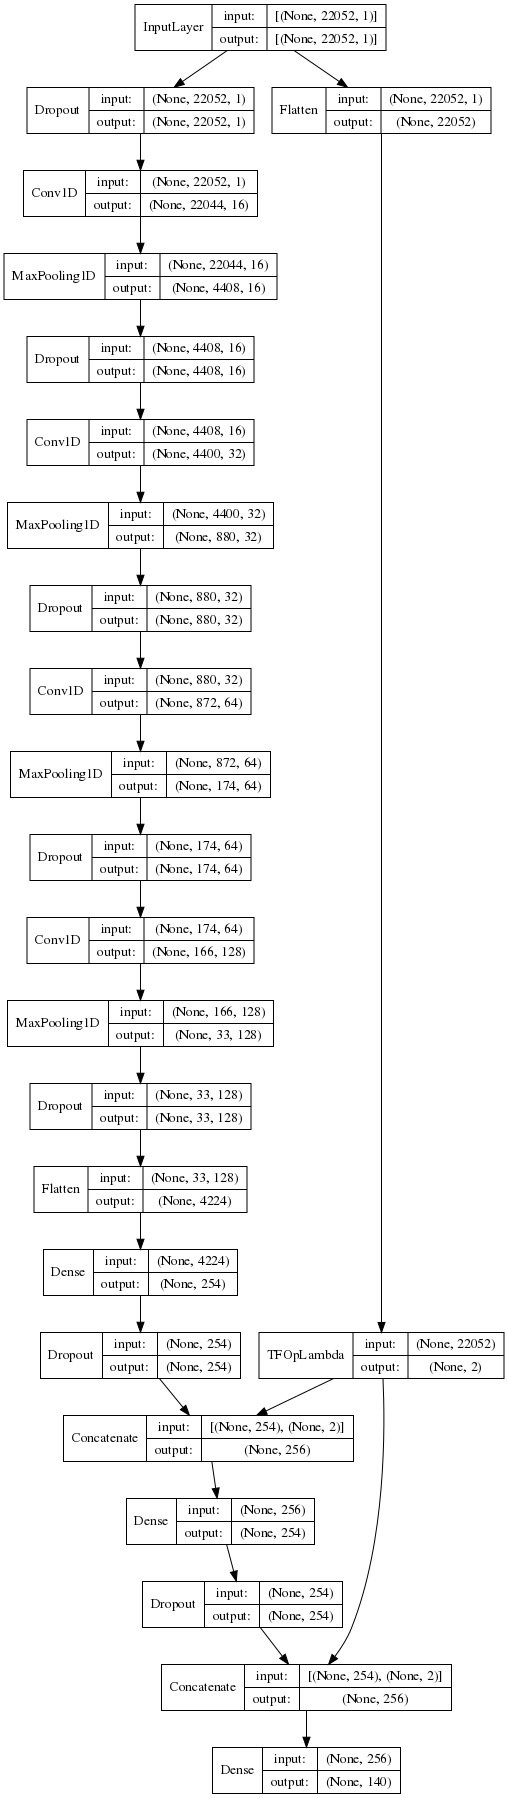

In [59]:
display(plot_model(model, show_layer_names=False, show_shapes=True, dpi=72))

In [22]:
# checkpoint_filepath = './cite_v32/checkpoint{epoch:02d}'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='loss', save_freq=15*100, save_best_only=False, mode='auto')

In [25]:
kf = KFold(n_splits = 8, shuffle = True, random_state=123)
score_list = []
b_size = 128
idx_tr, idx_va = next(kf.split(cite_train_x_raw))

In [26]:
training_generator = MultiomeSequence(cite_train_x_raw_new[idx_tr], cite_train_y_raw[idx_tr], batch_size=b_size)
validation_generator = MultiomeSequence(cite_train_x_raw_new[idx_va], cite_train_y_raw[idx_va], batch_size=b_size)
# retraining_generator = MultiomeSequence(cite_train_x_raw_new, cite_train_y_raw, batch_size=b_size)

In [25]:
# model.load_weights("./model/cite_v35")

In [60]:
epoc=300
# train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epochs, verbose=1,validation_freq=5, callbacks=[model_checkpoint_callback])
train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5)

Epoch 1/300
485/485 [==============================] - 17s 33ms/step - loss: -0.7768
Epoch 2/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8034
Epoch 3/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8046
Epoch 4/300
485/485 [==============================] - 16s 34ms/step - loss: -0.8047
Epoch 5/300
485/485 [==============================] - 17s 35ms/step - loss: -0.8048 - val_loss: -0.8077
Epoch 6/300
485/485 [==============================] - 16s 34ms/step - loss: -0.8049
Epoch 7/300
485/485 [==============================] - 16s 34ms/step - loss: -0.8048
Epoch 8/300
485/485 [==============================] - 16s 34ms/step - loss: -0.8049
Epoch 9/300
485/485 [==============================] - 16s 34ms/step - loss: -0.8049
Epoch 10/300
485/485 [==============================] - 17s 35ms/step - loss: -0.8049 - val_loss: -0.8078
Epoch 11/300
485/485 [==============================] - 16s 34ms/step - loss: -0.8048
Epoch 12/300
485/485 [=

485/485 [==============================] - 16s 33ms/step - loss: -0.8788
Epoch 93/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8777
Epoch 94/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8790
Epoch 95/300
485/485 [==============================] - 17s 35ms/step - loss: -0.8789 - val_loss: -0.8883
Epoch 96/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8781
Epoch 97/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8781
Epoch 98/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8780
Epoch 99/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8787
Epoch 100/300
485/485 [==============================] - 17s 35ms/step - loss: -0.8790 - val_loss: -0.8872
Epoch 101/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8781
Epoch 102/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8788
Epoch 103/300
485/485 [=

485/485 [==============================] - 16s 33ms/step - loss: -0.8808
Epoch 183/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8806
Epoch 184/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8808
Epoch 185/300
485/485 [==============================] - 17s 35ms/step - loss: -0.8801 - val_loss: -0.8897
Epoch 186/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8806
Epoch 187/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8803
Epoch 188/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8808
Epoch 189/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8808
Epoch 190/300
485/485 [==============================] - 17s 35ms/step - loss: -0.8780 - val_loss: -0.8889
Epoch 191/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8799
Epoch 192/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8795
Epoch 193/300
485

485/485 [==============================] - 16s 33ms/step - loss: -0.8795
Epoch 273/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8808
Epoch 274/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8812
Epoch 275/300
485/485 [==============================] - 17s 35ms/step - loss: -0.8812 - val_loss: -0.8905
Epoch 276/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8813
Epoch 277/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8815
Epoch 278/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8814
Epoch 279/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8805
Epoch 280/300
485/485 [==============================] - 17s 35ms/step - loss: -0.8812 - val_loss: -0.8904
Epoch 281/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8814
Epoch 282/300
485/485 [==============================] - 16s 33ms/step - loss: -0.8814
Epoch 283/300
485

In [65]:
epoc=1000
# train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epochs, verbose=1,validation_freq=5, callbacks=[model_checkpoint_callback])
train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5)

Epoch 1/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8816
Epoch 2/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8811
Epoch 3/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8814
Epoch 4/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8779
Epoch 5/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8799 - val_loss: -0.8900
Epoch 6/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8806
Epoch 7/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8810
Epoch 8/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8811
Epoch 9/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8812
Epoch 10/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8813 - val_loss: -0.8906
Epoch 11/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8815
Epoch 12/100

485/485 [==============================] - 16s 33ms/step - loss: -0.8811
Epoch 92/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8807
Epoch 93/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8816
Epoch 94/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8805
Epoch 95/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8812 - val_loss: -0.8905
Epoch 96/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8815
Epoch 97/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8816
Epoch 98/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8819
Epoch 99/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8820
Epoch 100/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8822 - val_loss: -0.8913
Epoch 101/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8824
Epoch 102/1000


485/485 [==============================] - 17s 35ms/step - loss: -0.8826 - val_loss: -0.8919
Epoch 181/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8827
Epoch 182/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8828
Epoch 183/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8825
Epoch 184/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8827
Epoch 185/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8824 - val_loss: -0.8920
Epoch 186/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8818
Epoch 187/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8826
Epoch 188/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8819
Epoch 189/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8824
Epoch 190/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8827 - val_l

485/485 [==============================] - 16s 33ms/step - loss: -0.8832
Epoch 270/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8832 - val_loss: -0.8923
Epoch 271/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8831
Epoch 272/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8830
Epoch 273/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8831
Epoch 274/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8834
Epoch 275/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8832 - val_loss: -0.8913
Epoch 276/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8832
Epoch 277/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8831
Epoch 278/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8832
Epoch 279/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8834
Epoch 2

485/485 [==============================] - 16s 33ms/step - loss: -0.8835
Epoch 359/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8835
Epoch 360/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8835 - val_loss: -0.8927
Epoch 361/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8836
Epoch 362/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8834
Epoch 363/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8835
Epoch 364/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8830
Epoch 365/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8832 - val_loss: -0.8926
Epoch 366/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8833
Epoch 367/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8831
Epoch 368/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8832
Epoch 3

485/485 [==============================] - 16s 33ms/step - loss: -0.8837
Epoch 448/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8837
Epoch 449/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8838
Epoch 450/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8838 - val_loss: -0.8926
Epoch 451/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8838
Epoch 452/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8839
Epoch 453/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8836
Epoch 454/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8839
Epoch 455/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8837 - val_loss: -0.8930
Epoch 456/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8835
Epoch 457/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.88390s - los

485/485 [==============================] - 16s 33ms/step - loss: -0.8840
Epoch 537/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8839
Epoch 538/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8840
Epoch 539/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8838
Epoch 540/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8840 - val_loss: -0.8923
Epoch 541/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8841
Epoch 542/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8842
Epoch 543/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8842
Epoch 544/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8836
Epoch 545/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8842 - val_loss: -0.8928
Epoch 546/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8840
Epoch 5

485/485 [==============================] - 17s 35ms/step - loss: -0.8835 - val_loss: -0.8931
Epoch 626/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8837
Epoch 627/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8838
Epoch 628/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8840
Epoch 629/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8841
Epoch 630/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8842 - val_loss: -0.8930
Epoch 631/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8843
Epoch 632/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8844
Epoch 633/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8843
Epoch 634/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8843
Epoch 635/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8845 - val_l

485/485 [==============================] - 16s 33ms/step - loss: -0.8845
Epoch 715/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8844 - val_loss: -0.8934
Epoch 716/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8846
Epoch 717/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8844
Epoch 718/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8845
Epoch 719/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8846
Epoch 720/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8845 - val_loss: -0.8932
Epoch 721/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8846
Epoch 722/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8845
Epoch 723/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8846
Epoch 724/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8845
Epoch 7

485/485 [==============================] - 16s 33ms/step - loss: -0.8848
Epoch 804/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8847
Epoch 805/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8845 - val_loss: -0.8933
Epoch 806/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8848
Epoch 807/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8845
Epoch 808/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8844
Epoch 809/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8847
Epoch 810/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8847 - val_loss: -0.8932
Epoch 811/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8847
Epoch 812/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8847
Epoch 813/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8846
Epoch 8

485/485 [==============================] - 16s 33ms/step - loss: -0.8843
Epoch 893/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8838
Epoch 894/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8846
Epoch 895/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8846 - val_loss: -0.8936
Epoch 896/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8849
Epoch 897/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8849
Epoch 898/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8850
Epoch 899/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8848
Epoch 900/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8849 - val_loss: -0.8934
Epoch 901/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8849
Epoch 902/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8850
Epoch 9

485/485 [==============================] - 16s 33ms/step - loss: -0.8851
Epoch 982/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8850
Epoch 983/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8852
Epoch 984/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8849
Epoch 985/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8849 - val_loss: -0.8937
Epoch 986/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8850
Epoch 987/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8851
Epoch 988/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8847
Epoch 989/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8849
Epoch 990/1000
485/485 [==============================] - 17s 35ms/step - loss: -0.8852 - val_loss: -0.8934
Epoch 991/1000
485/485 [==============================] - 16s 33ms/step - loss: -0.8851
Epoch 9

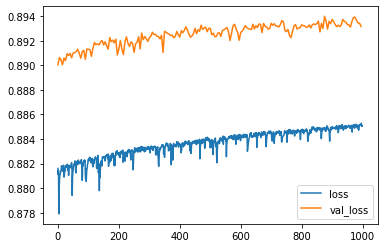

In [66]:
plt.plot(list(range(epoc)),np.array(train_hist.history['loss'])*(-1),label='loss')
plt.plot(list(range(0,epoc,5)),np.array(train_hist.history['val_loss'])*(-1),label='val_loss')
plt.legend(['loss', 'val_loss'])

In [ ]:
epoc=2000
# train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epochs, verbose=1,validation_freq=5, callbacks=[model_checkpoint_callback])
train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5)

In [67]:
model.save("./model/cite_v36_cont")

INFO:tensorflow:Assets written to: ./model/cite_v36_cont/assets


In [62]:
# del model
gc.collect()
K.clear_session()


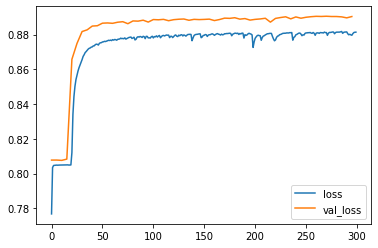

In [63]:
plt.plot(list(range(epoc)),np.array(train_hist.history['loss'])*(-1),label='loss')
plt.plot(list(range(0,epoc,5)),np.array(train_hist.history['val_loss'])*(-1),label='val_loss')
plt.legend(['loss', 'val_loss'])

In [ ]:
train_hist.history

In [ ]:
cite_train_x_gen = MultiomeSequence_test(cite_train_x_raw, batch_size=4)
train_pred_y = model.predict(cite_train_x_gen)

In [ ]:
train_pred_y.shape

In [ ]:
pd.DataFrame(train_pred_y.reshape(-1)).hist(bins=500)

In [ ]:
pd.DataFrame(cite_train_y_raw.reshape(-1)).hist(bins=500)
plt.xlim(-5,20)

In [ ]:
cite_train_y_raw.shape

In [ ]:
CorrelationLoss_new()(train_pred_y, cite_train_y_raw)

In [ ]:
cite_train_x_raw.shape

In [ ]:
retraining_generator = MultiomeSequence(cite_train_x_raw, cite_train_y_raw, batch_size=b_size)

In [ ]:
%%time
# Cross-validation
# multi_train_x = multi_train_x_raw
# multi_train_y = multi_train_y_raw
gc.collect()
K.clear_session()
model = None
model = my_model_2(cite_train_x_raw.shape[1], cite_train_y_raw.shape[1], 4096, 4, init_dropout=0.2, layer_dropout=0.7, activation='selu')
print(model.summary())
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),loss = CorrelationLoss_new())

In [37]:
epoc = 6000
train_hist = model.fit(retraining_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5)

Epoch 1/1000
17/17 [==============================] - 15s 819ms/step - loss: -0.7471
Epoch 2/1000
17/17 [==============================] - 14s 823ms/step - loss: -0.8016
Epoch 3/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.8018
Epoch 4/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.8032
Epoch 5/1000
17/17 [==============================] - 29s 2s/step - loss: -0.8033 - val_loss: -0.8060
Epoch 6/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.8028
Epoch 7/1000
17/17 [==============================] - 14s 823ms/step - loss: -0.8023
Epoch 8/1000
17/17 [==============================] - 14s 820ms/step - loss: -0.8036
Epoch 9/1000
17/17 [==============================] - 14s 822ms/step - loss: -0.8035
Epoch 10/1000
17/17 [==============================] - 28s 2s/step - loss: -0.8034 - val_loss: -0.8056
Epoch 11/1000
17/17 [==============================] - 14s 822ms/step - loss: -0.8042
Epoch 12/1000
17/17 [========

17/17 [==============================] - 14s 821ms/step - loss: -0.9003
Epoch 183/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.9007
Epoch 184/1000
17/17 [==============================] - 14s 820ms/step - loss: -0.9009
Epoch 185/1000
17/17 [==============================] - 28s 2s/step - loss: -0.9021 - val_loss: -0.9085
Epoch 186/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.9016
Epoch 187/1000
17/17 [==============================] - 14s 823ms/step - loss: -0.9015
Epoch 188/1000
17/17 [==============================] - 14s 823ms/step - loss: -0.9008
Epoch 189/1000
17/17 [==============================] - 14s 819ms/step - loss: -0.9011
Epoch 190/1000
17/17 [==============================] - 28s 2s/step - loss: -0.9020 - val_loss: -0.9091
Epoch 191/1000
17/17 [==============================] - 14s 823ms/step - loss: -0.9025
Epoch 192/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.9026
Epoch 193/1000
17/17 [==

KeyboardInterrupt: 

In [ ]:
epoc = 1000
train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5)

# Predicting

In [44]:
cite_test_df = pd.read_hdf(FP_CITE_TEST_INPUTS)
cite_test_df = cite_test_df.merge(cell_df, how='left',left_on='cell_id', right_on='cell_id').set_index('cell_id')
cite_test_x = cite_test_df.values
cite_test_x.shape

(48663, 22052)

In [45]:
cite_test_x_gen = MultiomeSequence_test(cite_test_x, batch_size=9)

In [46]:
test_pred = model.predict(cite_test_x_gen)

In [64]:
test_pred=test_pred/2000

In [66]:
test_pred.shape

(48663, 140)

In [48]:
test_pred

array([[-16872.78  , -16529.574 , -14850.824 , ..., -16382.986 ,
         -5617.318 ,  -9523.265 ],
       [-15983.761 , -15896.216 , -14268.212 , ..., -14856.228 ,
         -5932.4873,  -8633.405 ],
       [-13394.605 , -11822.872 , -10215.061 , ..., -12998.426 ,
         12856.708 ,  -5741.645 ],
       ...,
       [-20151.12  , -11562.627 , -14371.454 , ..., -18493.584 ,
        -15040.005 ,  -4159.7075],
       [-18793.92  , -15940.084 , -12431.3   , ..., -17092.123 ,
         24560.777 ,   7430.989 ],
       [-17449.967 , -14142.281 , -10855.673 , ..., -15670.2705,
         31288.357 ,   9102.683 ]], dtype=float32)

In [49]:
gc.collect()

24749

In [69]:
submission_prev = pd.read_csv('submission 804 NN.csv')['target']

In [70]:
submission_prev

0           9.460453e-02
1          -1.623624e-01
2          -4.053319e-01
3          -3.025821e-01
4           1.114355e+00
                ...     
65744175    9.840503e+09
65744176    0.000000e+00
65744177    0.000000e+00
65744178    1.860109e+09
65744179    9.638013e+09
Name: target, Length: 65744180, dtype: float64

In [71]:
test_pred.ravel().shape

(6812820,)

In [72]:
submission_prev.iloc[:len(test_pred.ravel())] = test_pred.ravel()

In [73]:
submission_prev = pd.DataFrame(submission_prev)

In [74]:
submission_prev.index.name="row_id"

In [75]:
submission_prev

,target
row_id,
0,-8.436390e+00
1,-8.264787e+00
2,-7.425412e+00
3,2.052546e+00
4,5.813356e+00
...,...
65744175,9.840503e+09
65744176,0.000000e+00
65744177,0.000000e+00


In [76]:
submission_prev.to_csv("submission.csv")